In [326]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [327]:
error_types = pd.read_csv('./error_type_meaning.csv')
structural_error_types = error_types[error_types.structural==True]['error_type'].tolist()
berzak_error_types = ['TV', 'RT', 'MD', 'FV', 'W', 'MT', 'UD', 'UT', 'MA', 'AGV',
                      'FN', 'RA', 'AGN', 'RD', 'DJ', 'DN', 'DY', 'UA', 'MC', 'RC']
spelling_error_types = ['S', 'SA', 'SX']
discarded_languages =['Swedish', 'Dutch']

In [328]:
df = pd.read_csv('./main_parser2.csv')
df = df[df.error_type.isin(structural_error_types)]
df = df[~df.language.isin(discarded_languages)]
error_type_count = df.groupby(['error_type']).size().reset_index(name='count')
error_type_count = error_type_count.assign(normalized=error_type_count['count'].div(error_type_count['count'].sum()))
#error_type_count = error_type_count[error_type_count.normalized > 0.01]
df = df[df.error_type.isin(error_type_count['error_type'].tolist())]

In [329]:
def concat_dummies(df, dummies):
    for dummy in list(dummies):
        df[dummy] = dummies[dummy]
    return list(dummies)

In [330]:
def create_dummies(df, column, prefix):
    dummies = pd.get_dummies(df[column], prefix=prefix)
    return concat_dummies(df, dummies)

In [331]:
c_first_pos = create_dummies(df, 'correct_trigram_tag_0', 'correct_trigram_tag_0')
c_second_pos = create_dummies(df, 'correct_trigram_tag_1', 'correct_trigram_tag_1')
c_third_pos = create_dummies(df, 'correct_trigram_tag_2', 'correct_trigram_tag_2')
i_first_pos = create_dummies(df, 'incorrect_trigram_tag_0', 'incorrect_trigram_tag_0')
i_second_pos = create_dummies(df, 'incorrect_trigram_tag_1', 'incorrect_trigram_tag_1')
i_third_pos = create_dummies(df, 'incorrect_trigram_tag_2', 'incorrect_trigram_tag_2')

In [332]:
c_first_dep = create_dummies(df, 'correct_trigram_dep_0', 'correct_trigram_dep_0')
c_second_dep = create_dummies(df, 'correct_trigram_dep_1', 'correct_trigram_dep_1')
c_third_dep = create_dummies(df, 'correct_trigram_dep_2', 'correct_trigram_dep_2')
i_first_dep = create_dummies(df, 'incorrect_trigram_dep_0', 'incorrect_trigram_dep_0')
i_second_dep = create_dummies(df, 'incorrect_trigram_dep_1', 'incorrect_trigram_dep_1')
i_third_dep = create_dummies(df, 'incorrect_trigram_dep_2', 'incorrect_trigram_dep_2')

In [333]:
languages = {'language': {'French': 1, 'Spanish': 2, 'Catalan': 3, 'Portuguese': 4, 'Italian': 5, 'Polish': 6, 'Russian': 7,
'Greek': 8,'German': 9, 'Japanese': 10, 'Korean': 11, 'Turkish': 12, 'Chinese': 13, 'Thai':14}}
df.replace(languages, inplace=True)

In [334]:
y = df['error_type']

In [335]:
tag_comparison_columns = ['0_0_tag', '0_1_tag', '0_2_tag', '1_0_tag', '1_1_tag', '1_2_tag',
                          '2_0_tag', '2_1_tag', '2_2_tag', '0_0_dep', '0_1_dep', '0_2_dep',
                          '1_0_dep', '1_1_dep', '1_2_dep', '2_0_dep', '2_1_dep', '2_2_dep']
error_related_columns = ['error_length'] + list(i_first_pos) + list(i_second_pos) +\
                         list(i_third_pos) + list(i_first_dep) + list(i_second_dep) +\
                         list(i_third_dep)
correction_related_columns = ['correction_length'] + list(c_first_pos) + list(c_second_pos) +\
                             list(c_third_pos) + list(c_first_dep) + list(c_second_dep) +\
                             list(c_third_dep)

features = error_related_columns + correction_related_columns +\
           tag_comparison_columns + ['language']
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
fit_data = x_train[features]
test_data = x_test[features]

In [336]:
clf = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
clf.fit(fit_data, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [337]:
clf.score(test_data, y_test)

0.8496568933250156

In [338]:
f = csv.writer(open('model_errors.csv', 'w'))
f.writerow(['wrong_errortype', 'correct_errortype', 'wrong_sentence', 'correct_sentence'])
predictions = clf.predict(test_data)
lines = x_test['incorrect_sentence'].tolist()
error_positions = x_test['incorrect_error_index'].tolist()
correct_sentences = x_test['correct_sentence'].tolist()
values = list(y_test)
real_y_spanish = []
predicted_y_spanish = []
for i in range(len(predictions)):
    if x_test['language'].values[i] == 2:
        real_y_spanish.append(values[i])
        predicted_y_spanish.append(predictions[i])
    if predictions[i] != values[i]:
        init = max(error_positions[i] - 3, 0)
        end = min(error_positions[i] + 3, len(lines[i].split()))
        f.writerow([predictions[i], values[i], lines[i], correct_sentences[i]])
predicted_y_spanish = np.reshape(predicted_y_spanish, len(predicted_y_spanish))
real_y_spanish = np.reshape(real_y_spanish, len(real_y_spanish))

In [339]:
def build_matrix(y_test, predictions):
    labels = sorted(list(set(list(y_test) + list(predictions))))
    cm = confusion_matrix(y_test, predictions, labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm_norm, cmap=plt.cm.Greys)
    plt.title('Confusion matrix of the error type classifier', fontsize=20)
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=18, rotation=90)
    ax.set_yticklabels(labels, fontsize=18)
    plt.xlabel('Predicted', fontsize=18, labelpad=20)
    plt.ylabel('True', fontsize=18)
    plt.savefig('confusion_matrix.png')

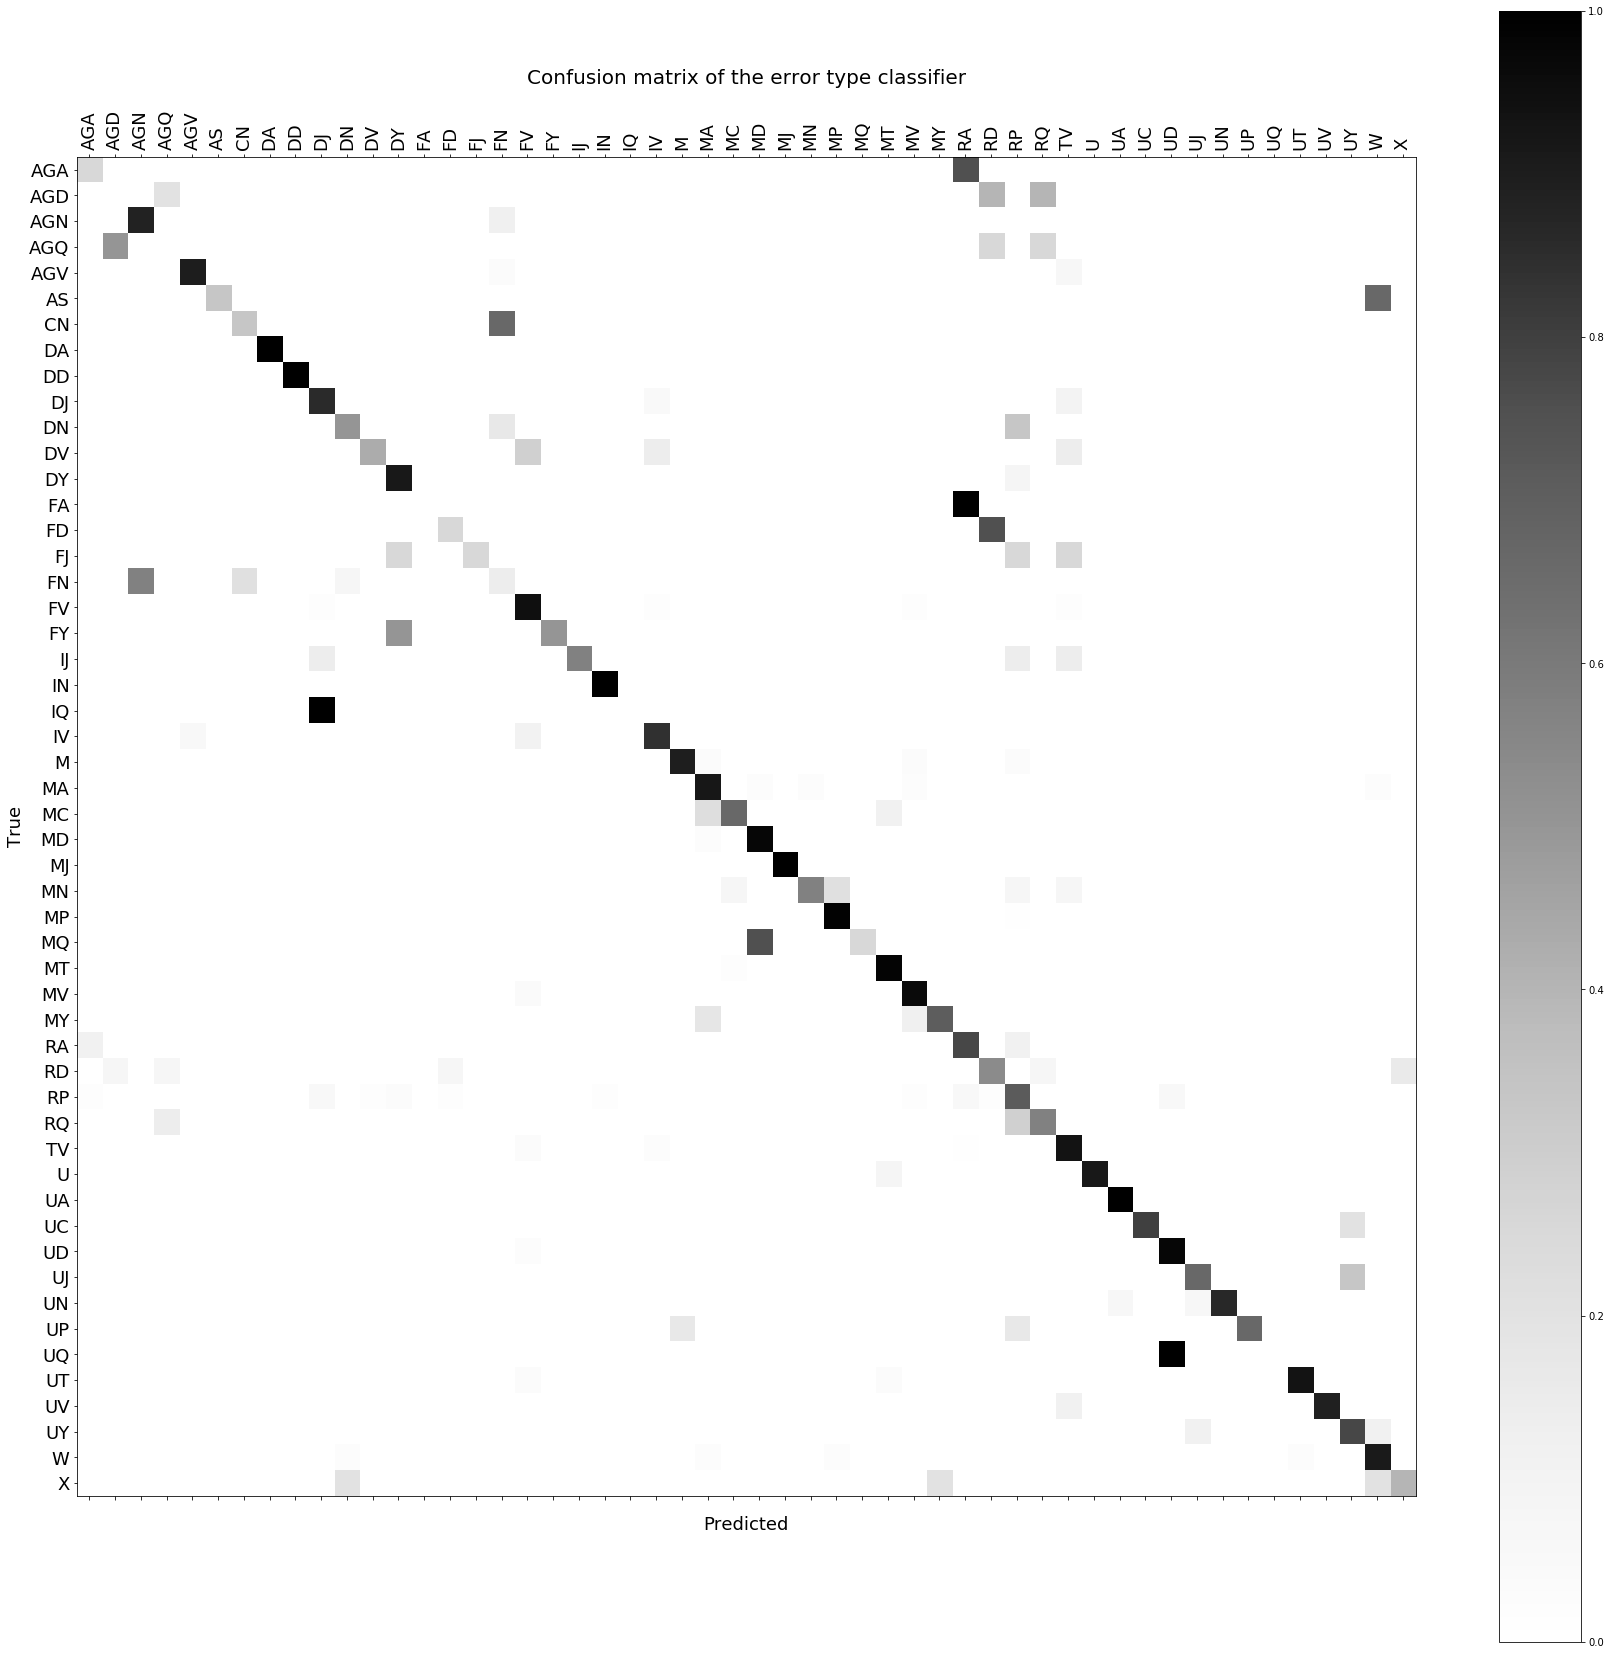

In [340]:
build_matrix(real_y_spanish, predicted_y_spanish) #Spanish

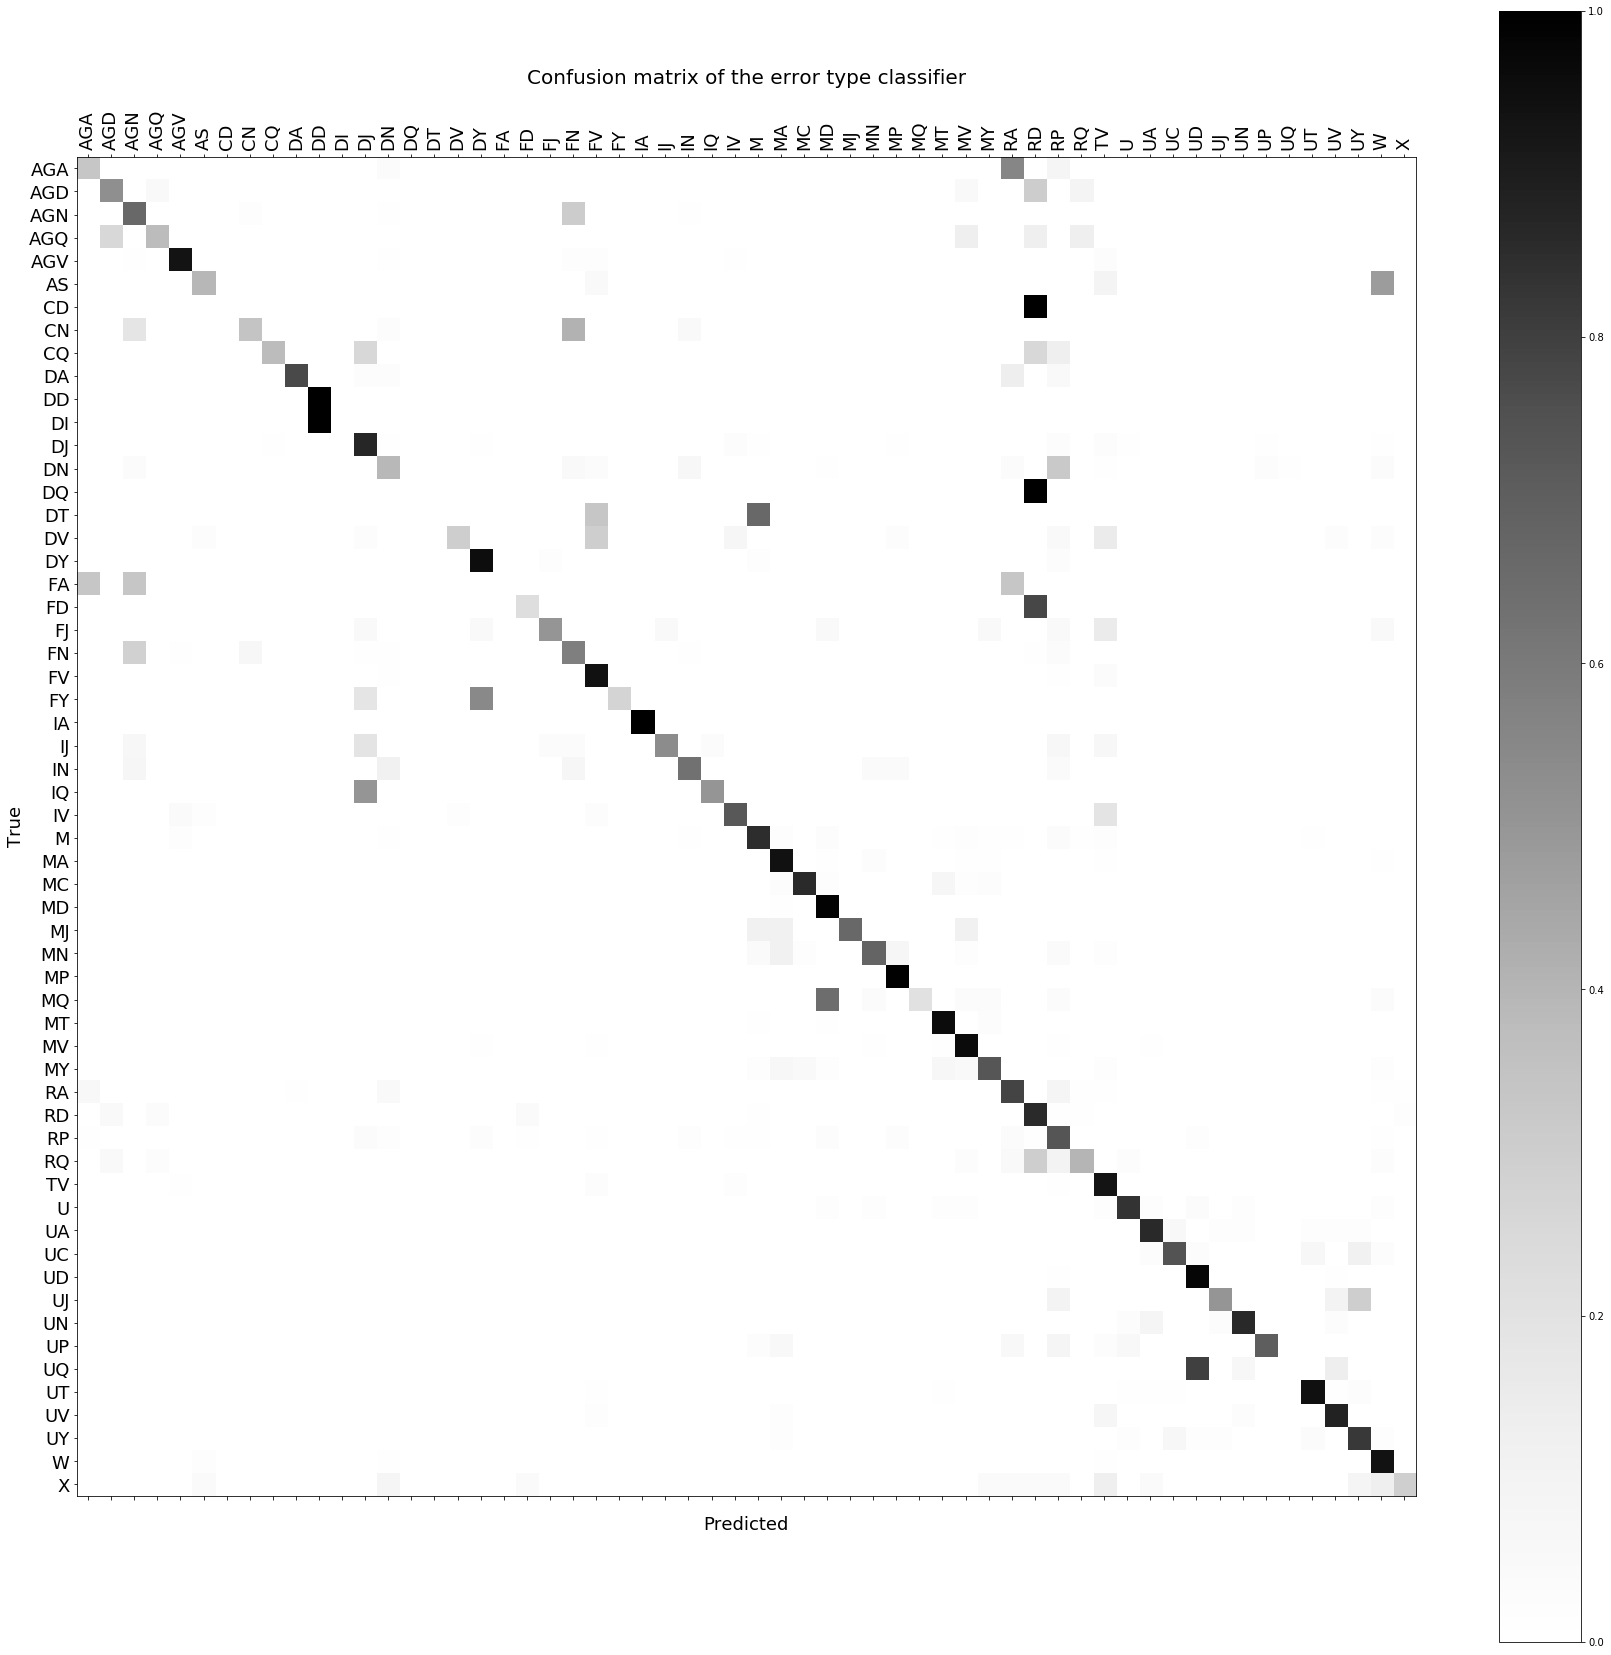

In [341]:
build_matrix(y_test, predictions)

In [309]:
importances = pd.DataFrame({'feature': list(fit_data), 'feature_importance': clf.feature_importances_})
importances = importances.set_index('feature')

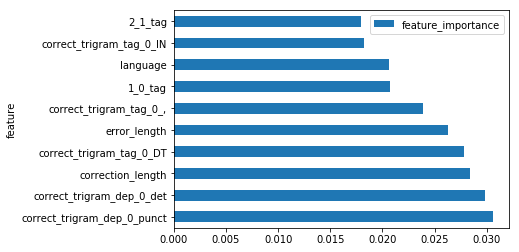

In [310]:
importances = importances.sort_values(by=['feature_importance'], ascending=False)
top_10 = importances[:10]
top_10.plot(kind='barh')

In [313]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(fit_data),
                   'importance': clf.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
print(fi.to_string())

                               feature    importance
446        correct_trigram_dep_0_punct  3.059422e-02
426          correct_trigram_dep_0_det  2.988930e-02
270                  correction_length  2.841581e-02
280           correct_trigram_tag_0_DT  2.787221e-02
0                         error_length  2.633835e-02
273            correct_trigram_tag_0_,  2.389206e-02
544                            1_0_tag  2.076233e-02
559                           language  2.065857e-02
284           correct_trigram_tag_0_IN  1.822152e-02
548                            2_1_tag  1.790204e-02
541                            0_0_tag  1.605667e-02
304          correct_trigram_tag_0_VBD  1.587418e-02
444         correct_trigram_dep_0_prep  1.570546e-02
155        incorrect_trigram_dep_0_det  1.569253e-02
10          incorrect_trigram_tag_0_DT  1.561704e-02
542                            0_1_tag  1.548806e-02
557                            2_1_dep  1.410672e-02
553                            1_0_dep  1.3938